## Markowitz portfolio optimization
### Mushfiqur Rahman [Mushfiq]

 In this notebook we optimize a portfolio of BTC, ETH, LTC and XRP. We extract the  BTC/USDT, ETH/USDT, LTC/USDT and XRP/USDT data from Poloneix. Since coins/USDT pairs are almost same as coins/USD pairs,it works for us. Later, perform monte carlo simulation to find the best Sharpe ratio for our portfolio. Finally, we apply Markowitz Portfolio Optimization.  


In [251]:
import os
import numpy as np
import pandas as pd
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [252]:
def get_json_data(json_url, cache_path):
    '''Download and cache JSON data, return as a dataframe.'''
    try:        
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(json_url))
    except (OSError, IOError) as e:
        print('Downloading {}'.format(json_url))
        df = pd.read_json(json_url)
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(json_url, cache_path))
    return df


In [253]:
base_polo_url = 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}'
start_date = datetime.strptime('2016-01-01', '%Y-%m-%d') 
end_date = datetime.now() # up until today
period = 86400 # pull daily data (86,400 seconds per day)

def get_crypto_data(poloniex_pair):
    '''Retrieve cryptocurrency data from poloniex'''
    json_url = base_polo_url.format(poloniex_pair, start_date.timestamp(), end_date.timestamp(), period)
    data_df = get_json_data(json_url, poloniex_pair)
    data_df = data_df.set_index('date')
    return data_df

In [254]:
crypto = ['ETH','LTC','XRP','ETC','BTC','BCH']

crypto_data = {}
for coin in crypto:
    coinpair = 'USDT_{}'.format(coin)
    crypto_price_df = get_crypto_data(coinpair)
    crypto_data[coin] = crypto_price_df


Loaded https://poloniex.com/public?command=returnChartData&currencyPair=USDT_ETH&start=1451624400.0&end=1530986285.064943&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=USDT_LTC&start=1451624400.0&end=1530986285.064943&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=USDT_XRP&start=1451624400.0&end=1530986285.064943&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=USDT_ETC&start=1451624400.0&end=1530986285.064943&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=USDT_BTC&start=1451624400.0&end=1530986285.064943&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=USDT_BCH&start=1451624400.0&end=1530986285.064943&period=86400 from cache


In [255]:
crypto_data['BTC'].head()

,close,high,low,open,quoteVolume,volume,weightedAverage
date,,,,,,,
2016-01-02,436.949900,438.140000,430.500000,434.990000,2.179981,944.853289,433.422678
2016-01-03,428.140000,435.614998,426.453089,432.310000,1.596349,683.918470,428.426673
2016-01-04,432.000011,435.999999,427.291140,427.291141,1.673428,724.976004,433.228179
2016-01-05,430.376774,435.999999,429.569500,430.140211,0.992530,427.647283,430.865842
2016-01-06,427.500020,435.000000,427.290001,430.170473,1.903358,819.344827,430.473321


In [256]:
dfp = pd.concat([crypto_data['BTC']['close'],crypto_data['ETH']['close'],crypto_data['LTC']['close'],crypto_data['XRP']['close']], axis=1)

In [257]:
dfp.head()

,close,close,close,close
date,,,,
2016-01-02,436.949900,0.957000,3.569990,0.006127
2016-01-03,428.140000,0.960499,3.435230,0.006149
2016-01-04,432.000011,0.962224,3.435230,0.006149
2016-01-05,430.376774,0.939382,3.435234,0.006149
2016-01-06,427.500020,0.938000,3.455243,0.006106


In [258]:
dfp.columns = ['BTC','ETH', 'LTC','XRP']

In [259]:
dfp.tail()

,BTC,ETH,LTC,XRP
date,,,,
2018-07-03,6497.659409,462.309791,84.901415,0.484567
2018-07-04,6585.603139,467.333029,85.315319,0.490000
2018-07-05,6532.215386,467.260796,83.292341,0.478700
2018-07-06,6605.000000,469.352395,82.837624,0.476600
2018-07-07,6577.384614,467.493236,82.140196,0.469600


In [260]:
dfp = dfp.loc['2017-01-01':] # Keeping the data from 2017

In [261]:
mean_daily_ret = dfp.pct_change(1).mean()
mean_daily_ret

BTC    0.004695
ETH    0.009622
LTC    0.008355
XRP    0.013838
dtype: float64

In [262]:
dfp.pct_change(1).corr()  # Correlation matrix

,BTC,ETH,LTC,XRP
BTC,1.000000,0.510953,0.502848,0.242841
ETH,0.510953,1.000000,0.458816,0.231729
LTC,0.502848,0.458816,1.000000,0.313585
XRP,0.242841,0.231729,0.313585,1.000000


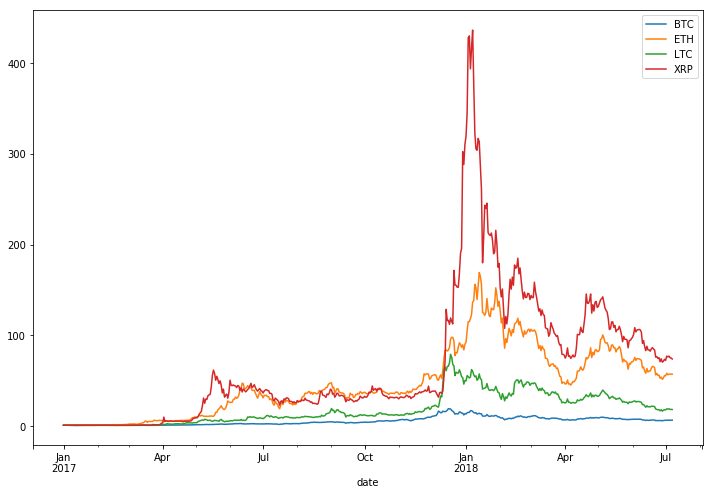

In [263]:
crypto_normed = dfp/dfp.iloc[0]
crypto_normed['2017-01-01':].plot(figsize=(12,8))

In [264]:
dfp.head()

,BTC,ETH,LTC,XRP
date,,,,
2017-01-01,999.364640,8.161638,4.486000,0.006346
2017-01-02,1019.000001,8.389086,4.605872,0.006316
2017-01-03,1037.100000,9.653000,4.590000,0.006411
2017-01-04,1136.000000,11.100000,4.603085,0.006613
2017-01-05,998.800000,10.090000,4.241776,0.006300


In [265]:
crypto_daily_ret = dfp.pct_change(1)  # Daily return
crypto_daily_ret.head()

,BTC,ETH,LTC,XRP
date,,,,
2017-01-01,NaN,NaN,NaN,NaN
2017-01-02,0.019648,0.027868,0.026721,-0.004636
2017-01-03,0.017763,0.150662,-0.003446,0.014982
2017-01-04,0.095362,0.149902,0.002851,0.031588
2017-01-05,-0.120775,-0.090991,-0.078493,-0.047392


In [266]:
log_ret = np.log(dfp/dfp.shift(1))  #Log return
log_ret.head()

,BTC,ETH,LTC,XRP
date,,,,
2017-01-01,NaN,NaN,NaN,NaN
2017-01-02,0.019457,0.027487,0.026370,-0.004647
2017-01-03,0.017607,0.140337,-0.003452,0.014871
2017-01-04,0.091085,0.139676,0.002847,0.031100
2017-01-05,-0.128714,-0.095400,-0.081745,-0.048551


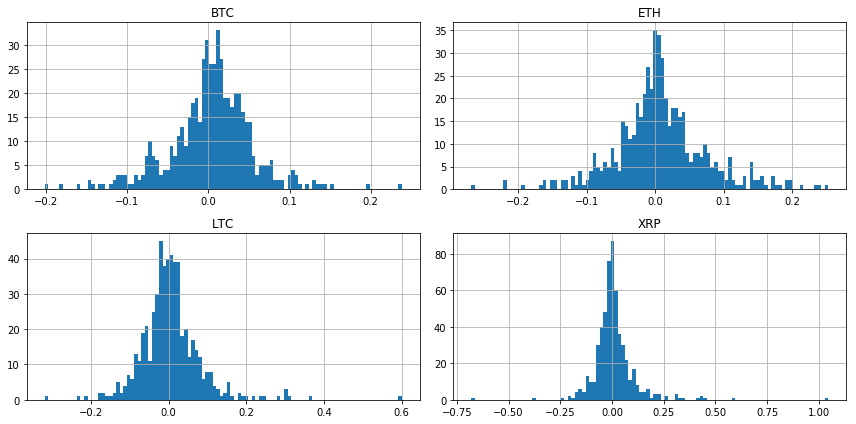

In [267]:
log_ret.hist(bins=100,figsize=(12,6));
plt.tight_layout()

In [268]:
log_ret.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
BTC,552.0,0.003414,0.050498,-0.201410,-0.020466,0.005619,0.032376,0.238142
ETH,552.0,0.007333,0.066859,-0.268442,-0.025241,0.003809,0.036809,0.252744
LTC,552.0,0.005267,0.076637,-0.318535,-0.032980,-0.000095,0.034193,0.600512
XRP,552.0,0.007797,0.103825,-0.680387,-0.036252,-0.001774,0.031956,1.046054


In [269]:
log_ret.mean() * 252

BTC    0.860211
ETH    1.847973
LTC    1.327321
XRP    1.964918
dtype: float64

In [270]:
log_ret.cov()

,BTC,ETH,LTC,XRP
BTC,0.002550,0.001811,0.002150,0.001611
ETH,0.001811,0.004470,0.002619,0.002183
LTC,0.002150,0.002619,0.005873,0.003011
XRP,0.001611,0.002183,0.003011,0.010780


In [271]:
num_ports = 10000

all_weights = np.zeros((num_ports,len(dfp.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports):

    # Create Random Weights
    weights = np.array(np.random.random(4))

    # Rebalance Weights
    weights = weights / np.sum(weights)
    
    # Save Weights
    all_weights[ind,:] = weights

    # Expected Return
    ret_arr[ind] = np.sum((log_ret.mean() * weights) *252)

    # Expected Variance
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))

    # Sharpe Ratio
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

In [272]:
sharpe_arr.max()

1.8690122819659307

In [273]:
sharpe_arr.argmax()

7390

In [274]:
all_weights[sharpe_arr.argmax(),:]

array([0.0428086 , 0.74399954, 0.00615664, 0.20703522])

In [275]:
dfp.columns

Index(['BTC', 'ETH', 'LTC', 'XRP'], dtype='object')

In [276]:
max_sr_ret = ret_arr[sharpe_arr.argmax()]
max_sr_vol = vol_arr[sharpe_arr.argmax()]
print('Return with Maximum SR')
print(max_sr_ret)
print('Volality with Maximum SR')
print(max_sr_vol)

Return with Maximum SR
1.826694234835702
Volality with Maximum SR
0.977358068997965


## So according to the analysis 70% of our portfolio should be allocated to Etherum ! 

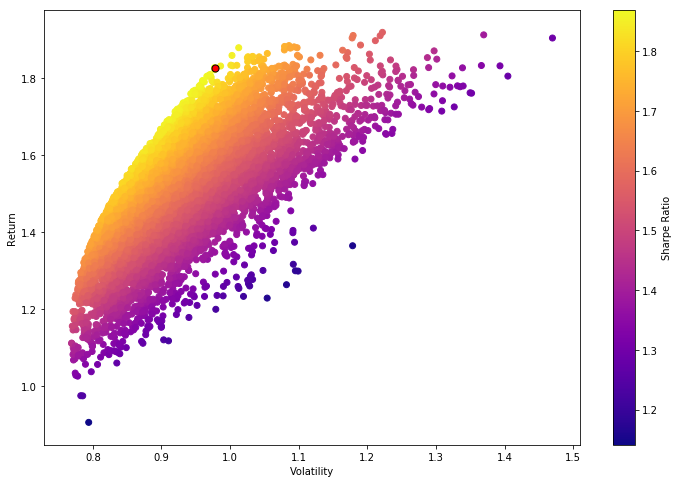

In [277]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

# Add red dot for max SR
plt.scatter(max_sr_vol,max_sr_ret,c='red',s=50,edgecolors='black')

In [278]:
## Efficient Frontier
# Our returns go from 0 to somewhere along 0.3
# Create a linspace number of points to calculate x on
frontier_y = np.linspace(.9,1.8,50) # Change 100 to a lower number for slower computers!

In [279]:
# Contraints
def check_sum(weights):
    '''
    Returns 0 if sum of weights is 1.0
    '''
    return np.sum(weights) - 1

In [280]:
def minimize_volatility(weights):
    return  get_ret_vol_sr(weights)[1] 

In [281]:
def get_ret_vol_sr(weights):
    """
    Takes in weights, returns array or return,volatility, sharpe ratio
    """
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])

In [282]:
# 0-1 bounds for each weight
bounds = ((0, 1), (0, 1), (0, 1), (0, 1))

In [283]:
# Initial Guess (equal distribution)
init_guess = [0.25,0.25,0.25,0.25]

In [284]:
from scipy.optimize import minimize

In [285]:
frontier_volatility = []

for possible_return in frontier_y:
    # function for return
    cons = ({'type':'eq','fun': check_sum},
            {'type':'eq','fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
    
    frontier_volatility.append(result['fun'])

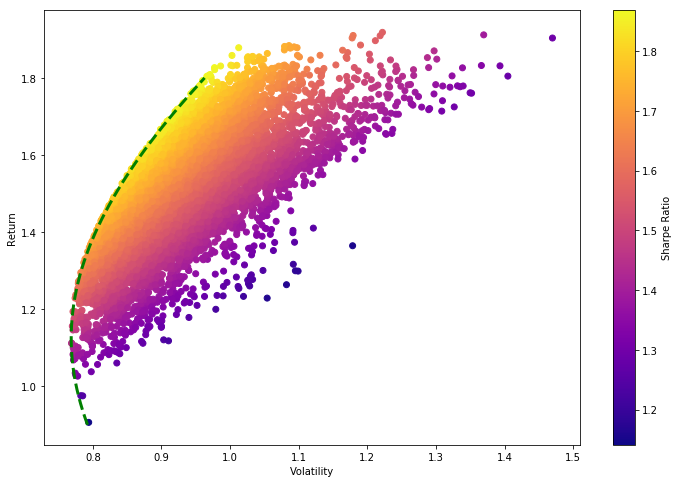

In [286]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')



# Add frontier line
plt.plot(frontier_volatility,frontier_y,'g--',linewidth=3)